# **Introduction, Function definition**
This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset. In addition different optimizers and its perfomance are evaluated. 

This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


In [2]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 2.0MB 16.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Let's define our model. The standard PyTorch way of doing so is to create a class inheriting from `torch.nn.Module`.

In its `__init__` method, we create the layers we are going to need and store them as member variables.

In its `forward` method we implement the forward pass computation, making use of the layers we created in the constructor.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now let's create a function that trains over an epoch. 
As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the **negative log likelihood** (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

And now let's create a similar function but to evaluate the performance of the model over a validation data set. Apart from the validation loss, we need to return the number of correct targets for the sake of visualization later.

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)
   
    return validation_loss, correct

Now, we will use the dataset from `torchvision` to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

Note that we apply a linear transformation to normalize the data.

In [7]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

Processing...
Done!


In order to test the different perfomances of the optimizers we define an evalatuation function `eval`. 

This function will have as an input the type of optimizer and its diferent parameters considering this order:


*   The first parameter will indicate the name of the desired optimization algorithm
   * If the selected algorithm is SGD:
      * The second parameter will be the learning rate (float)
      * The third parameter will be the momentum factor (float)
      * The fourth parameter will indicate if the Nesterov momentum is activated (0 for False 1 for True)
      * Example : `evalopt('SGD', 0.01, 0.5, 0)`
   * If the selected algorithm is Adam:
      * The second parameter will be the learning rate (float)
      * The third and fourth parameter will indicate the betas (floats)
      * Example: `evalopt('Adam', 0.01, 0.9, 0.99)`
    * If the selected algorithm is RMSprop:
      * The second parameter will be the learning rate (float)
      * Example: `evalopt('RMS', 0.01)`
    * If the selected algorithm is Adadelta:
      * The second parameter determines the rho (float)
      * Example: `evalopt('Delta', 0.95)`

    


The function will output the arrays in which the validation and train losses over the different epochs are stored, so that we can visualize the results of the different optimizers together. In addition the function will print the validation results at each epoch iteration.



In [0]:
def evalopt(*arg):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  
  # OPTIMIZER INIT
  if(arg[0] == 'SGD'):
    optimizer = optim.SGD(model.parameters(), lr=arg[1], momentum=arg[2], nesterov = arg[3])  
  elif(arg[0] == 'Adam'):
    optimizer = optim.Adam(model.parameters(), lr=arg[1], betas = (arg[2], arg[3]))
  elif(arg[0] == 'RMS'):
    optimizer = optim.RMSprop(model.parameters(), lr=arg[1])
  elif(arg[0] == 'Delta'):
    optimizer = optim.Adadelta(model.parameters(), rho=arg[1])
  print(optimizer)
  
  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
    train_losses.extend(epoch_losses)
    valid_loss, valid_correct = validate(model, device, valid_loader)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)
    print('Training with opt: {} -- Train epoch: {} -- Validation Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(arg[0], epoch, valid_loss, valid_correct, len(valid_loader.dataset), 100. * valid_correct / len(valid_loader.dataset)))

  return train_losses, valid_x, valid_losses

In order to be able to visualize the results of the different optimizers properly, we define a function `plots` which will allow us plot the evaluation curve of the input arrays of validation and train losses over  (output of the `eval` function.)

In [0]:
def plots(title, train_losses, valid_x, valid_losses):
  plt.gcf().clear()
  plt.suptitle(title)
  plt.plot(train_losses, 'b-')
  plt.plot(valid_x, valid_losses, 'r-')
  plt.xlabel('Trained Data')
  plt.ylabel('Loss')
  plt.show()

#**Optimizer Study**
Now we have defined everything we need to perform a proper analisys of the perfomance of different optimization algorithms, so the next step is to compute the evaluation with the diferent alogrithms and compare them.

## SGD Overview

In this section we will review the SGD algorithm, and the influence of its main parameters: the learning rate, the momentum and Nesterov momentum.

Fist let's see how the learning rate affects the error, for fixed momentum (0) and Nesterov momentum (deactivated).

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.04
    momentum: 0
    nesterov: 0
    weight_decay: 0
)
Training with opt: SGD -- Train epoch: 1 -- Validation Average loss: 0.1203, Accuracy: 9629/10000 (96%)
Training with opt: SGD -- Train epoch: 2 -- Validation Average loss: 0.0595, Accuracy: 9819/10000 (98%)
Training with opt: SGD -- Train epoch: 3 -- Validation Average loss: 0.0456, Accuracy: 9857/10000 (99%)
Training with opt: SGD -- Train epoch: 4 -- Validation Average loss: 0.0414, Accuracy: 9865/10000 (99%)
Training with opt: SGD -- Train epoch: 5 -- Validation Average loss: 0.0331, Accuracy: 9887/10000 (99%)
Training with opt: SGD -- Train epoch: 6 -- Validation Average loss: 0.0301, Accuracy: 9903/10000 (99%)
Training with opt: SGD -- Train epoch: 7 -- Validation Average loss: 0.0312, Accuracy: 9893/10000 (99%)
Training with opt: SGD -- Train epoch: 8 -- Validation Average loss: 0.0346, Accuracy: 9883/10000 (99%)
Training with opt: SGD -- Train epoch: 9 -- Validation Avera

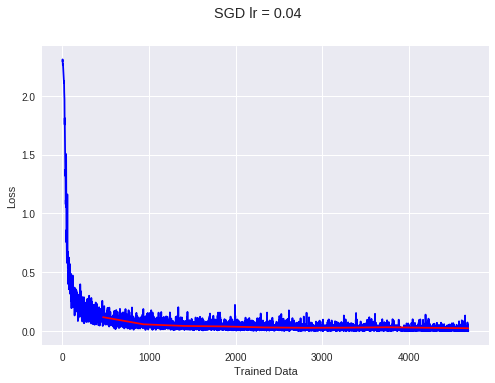

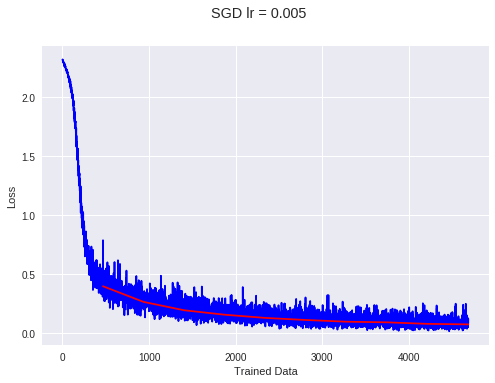

In [0]:
train_l_SGD_lr1, valid_x_SGD_lr1, valid_l_SGD_lr1 = evalopt('SGD', 0.04, 0, 0)
train_l_SGD_lr2, valid_x_SGD_lr2, valid_l_SGD_lr2 = evalopt('SGD', 0.005, 0, 0)
plots('SGD lr = 0.04', train_l_SGD_lr1, valid_x_SGD_lr1, valid_l_SGD_lr1)
plots('SGD lr = 0.005', train_l_SGD_lr2, valid_x_SGD_lr2, valid_l_SGD_lr2)

We can see in the above images that, although both algorithms converge, lower learning rates imply slower convergence. This makes perfect theoretical sense because the learning rate models how much the parameters will be updated according the inverse gradient direction of the loss function. 

Now let's study the influence of the momentum. To do so, we will compute SGD with the same learning rate as the last example, but with 0.5 momentum.

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.5
    nesterov: 0
    weight_decay: 0
)
Training with opt: SGD -- Train epoch: 1 -- Validation Average loss: 0.2564, Accuracy: 9233/10000 (92%)
Training with opt: SGD -- Train epoch: 2 -- Validation Average loss: 0.1467, Accuracy: 9569/10000 (96%)
Training with opt: SGD -- Train epoch: 3 -- Validation Average loss: 0.1128, Accuracy: 9653/10000 (97%)
Training with opt: SGD -- Train epoch: 4 -- Validation Average loss: 0.0933, Accuracy: 9717/10000 (97%)
Training with opt: SGD -- Train epoch: 5 -- Validation Average loss: 0.0722, Accuracy: 9787/10000 (98%)
Training with opt: SGD -- Train epoch: 6 -- Validation Average loss: 0.0629, Accuracy: 9807/10000 (98%)
Training with opt: SGD -- Train epoch: 7 -- Validation Average loss: 0.0562, Accuracy: 9827/10000 (98%)
Training with opt: SGD -- Train epoch: 8 -- Validation Average loss: 0.0578, Accuracy: 9816/10000 (98%)
Training with opt: SGD -- Train epoch: 9 -- Validation Av

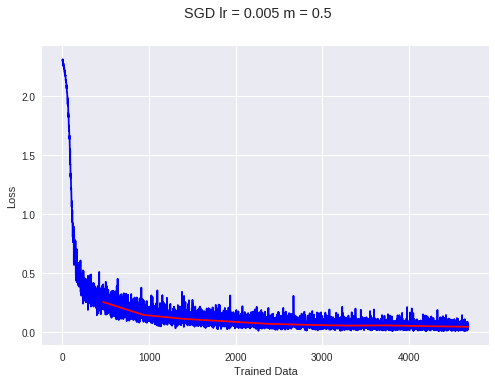

In [0]:
train_l_SGD_m, valid_x_SGD_m, valid_l_SGD_m = evalopt('SGD', 0.005, 0.5, 0)
plots('SGD lr = 0.005 m = 0.5', train_l_SGD_m, valid_x_SGD_m, valid_l_SGD_m)


As we can see momentum speeds up the converge of the algorithm because it introduces a certain sense of memory of the direction of the descend gradient, so the parameters can be directed faster towards the minima.

In order to properly test the Nesterov moment’s influence in the algorithm, let’s compare the losses of two networks with slow learning rates, one without the Nesterov accelerated gradient and the other with it.

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.5
    nesterov: 0
    weight_decay: 0
)
Training with opt: SGD -- Train epoch: 1 -- Validation Average loss: 1.0973, Accuracy: 7876/10000 (79%)
Training with opt: SGD -- Train epoch: 2 -- Validation Average loss: 0.4301, Accuracy: 8838/10000 (88%)
Training with opt: SGD -- Train epoch: 3 -- Validation Average loss: 0.3259, Accuracy: 9062/10000 (91%)
Training with opt: SGD -- Train epoch: 4 -- Validation Average loss: 0.2759, Accuracy: 9208/10000 (92%)
Training with opt: SGD -- Train epoch: 5 -- Validation Average loss: 0.2388, Accuracy: 9306/10000 (93%)
Training with opt: SGD -- Train epoch: 6 -- Validation Average loss: 0.2120, Accuracy: 9393/10000 (94%)
Training with opt: SGD -- Train epoch: 7 -- Validation Average loss: 0.1902, Accuracy: 9459/10000 (95%)
Training with opt: SGD -- Train epoch: 8 -- Validation Average loss: 0.1713, Accuracy: 9510/10000 (95%)
Training with opt: SGD -- Train epoch: 9 -- Validation Av

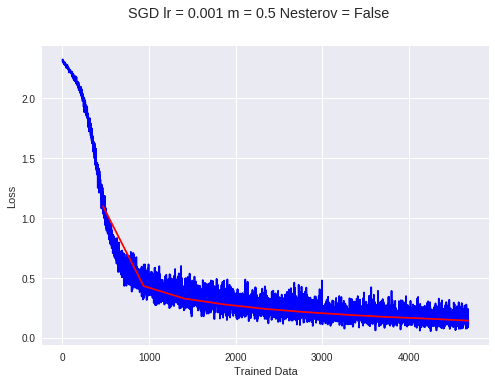

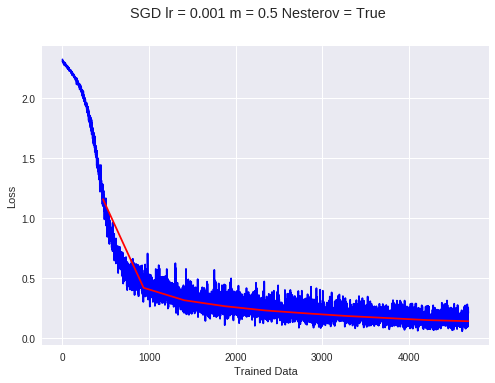

In [0]:
train_l_SGD_n1, valid_x_SGD_n1, valid_l_SGD_n1 = evalopt('SGD', 0.001, 0.5, 0)
train_l_SGD_n2, valid_x_SGD_n2, valid_l_SGD_n2 = evalopt('SGD', 0.001, 0.5, 1)
plots('SGD lr = 0.001 m = 0.5 Nesterov = False', train_l_SGD_n1, valid_x_SGD_n1, valid_l_SGD_n1)
plots('SGD lr = 0.001 m = 0.5 Nesterov = True', train_l_SGD_n2, valid_x_SGD_n2, valid_l_SGD_n2)


As it can be seen in the graphs and in the evolution of the Validation error trough the different epochs, the introduction of the Nesterov moment helps the algorithm converge faster as it uses the momentum to predict where the next update is going to be directed.



##Adam Overview

From the Adam analysis, in general, you must know that:
* Adaptive Moment Estimation (Adam) is an algorithm that computes adaptive learning rates for each parameter.
* Also, it keeps an exponentially decaying average of past gradients similar to momentum.
* Each beta is for one of the 2 estimations that you make, they are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method

Here we'll analyze how Adam works with the different values of learning rate and betas.

The betas are the coefficients used for computing running averages of gradient and its square 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.035
    weight_decay: 0
)
Training with opt: Adam -- Train epoch: 1 -- Validation Average loss: 2.3035, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 2 -- Validation Average loss: 2.3023, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 3 -- Validation Average loss: 2.3040, Accuracy: 1010/10000 (10%)
Training with opt: Adam -- Train epoch: 4 -- Validation Average loss: 2.3026, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 5 -- Validation Average loss: 2.3021, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 6 -- Validation Average loss: 2.3042, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 7 -- Validation Average loss: 2.3016, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 8 -- Validation Average loss: 2.3022, Accuracy: 1135/10000 (11%)
Training with opt: Adam -- Train epoch: 9 

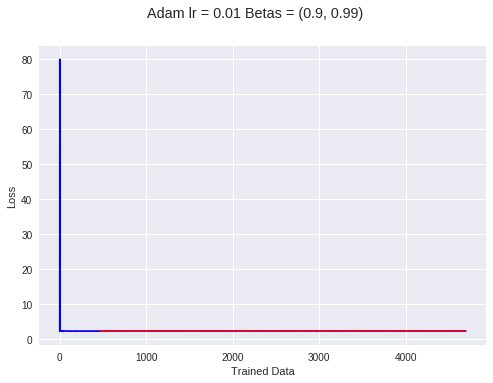

In [0]:
train_l_ADAM, valid_x_ADAM, valid_l_ADAM = evalopt('Adam', 0.035, 0.9, 0.99)
plots('Adam lr = 0.01 Betas = (0.9, 0.99)', train_l_ADAM, valid_x_ADAM, valid_l_ADAM)

As you can observe, with this value of learning rate, we suffer from overfitting, because the optimizer is learning too much the test and data and fails to create a general knowledge of it. 
No convergence, same and constant accuracy.
No convergence speed.

Now, we'll only modify the learning rate, this means that we'll lower it, because we are suffering overfitting.

As we researched, it is a good idea go down by one factor, so we'll use 0.001. Same betas as before (default ones).

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Training with opt: Adam -- Train epoch: 1 -- Validation Average loss: 0.0387, Accuracy: 9885/10000 (99%)
Training with opt: Adam -- Train epoch: 2 -- Validation Average loss: 0.0335, Accuracy: 9894/10000 (99%)
Training with opt: Adam -- Train epoch: 3 -- Validation Average loss: 0.0339, Accuracy: 9895/10000 (99%)
Training with opt: Adam -- Train epoch: 4 -- Validation Average loss: 0.0265, Accuracy: 9920/10000 (99%)
Training with opt: Adam -- Train epoch: 5 -- Validation Average loss: 0.0358, Accuracy: 9903/10000 (99%)
Training with opt: Adam -- Train epoch: 6 -- Validation Average loss: 0.0284, Accuracy: 9922/10000 (99%)
Training with opt: Adam -- Train epoch: 7 -- Validation Average loss: 0.0369, Accuracy: 9899/10000 (99%)
Training with opt: Adam -- Train epoch: 8 -- Validation Average loss: 0.0379, Accuracy: 9915/10000 (99%)
Training with opt: Adam -- Train epoch: 9 

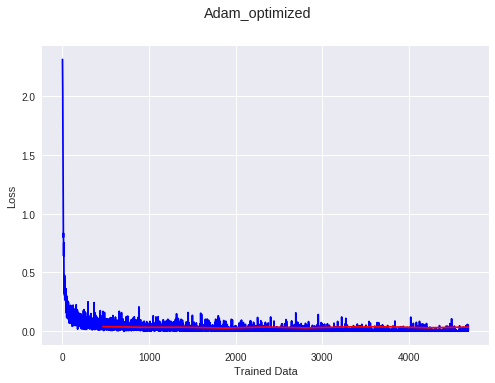

In [0]:
train_l_ADAM, valid_x_ADAM, valid_l_ADAM = evalopt('Adam', 0.001, 0.9, 0.99)
plots('Adam lr = 0.001 Betas = (0.9, 0.99)', train_l_ADAM, valid_x_ADAM, valid_l_ADAM)

As you can see, it works perfectly right now, we have convergence, losses became really low form the begginning, that's a  fast convergence and the accuracy (on the ppt we have the values of the accuracy on the validation data, we deleted it in order to not have a lot of data showed on the executions), but we can conclude that is the best yet.

Let's observe with an even lower learning rate what happens:

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Training with opt: Adam -- Train epoch: 1 -- Validation Average loss: 0.1539, Accuracy: 9523/10000 (95%)
Training with opt: Adam -- Train epoch: 2 -- Validation Average loss: 0.0874, Accuracy: 9745/10000 (97%)
Training with opt: Adam -- Train epoch: 3 -- Validation Average loss: 0.0651, Accuracy: 9800/10000 (98%)
Training with opt: Adam -- Train epoch: 4 -- Validation Average loss: 0.0508, Accuracy: 9834/10000 (98%)
Training with opt: Adam -- Train epoch: 5 -- Validation Average loss: 0.0466, Accuracy: 9847/10000 (98%)
Training with opt: Adam -- Train epoch: 6 -- Validation Average loss: 0.0431, Accuracy: 9856/10000 (99%)
Training with opt: Adam -- Train epoch: 7 -- Validation Average loss: 0.0399, Accuracy: 9859/10000 (99%)
Training with opt: Adam -- Train epoch: 8 -- Validation Average loss: 0.0360, Accuracy: 9886/10000 (99%)
Training with opt: Adam -- Train epoch: 9

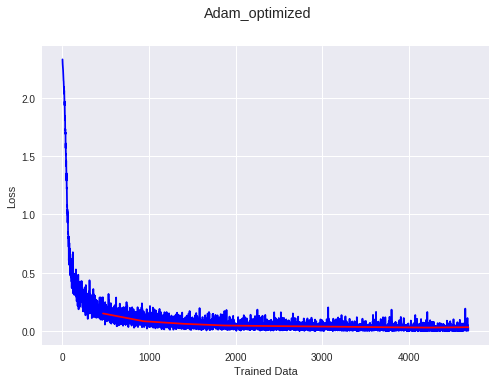

In [0]:
train_l_ADAM, valid_x_ADAM, valid_l_ADAM = evalopt('Adam', 0.0001, 0.9, 0.99)
plots('Adam lr = 0.0001 Betas = (0.9, 0.99)', train_l_ADAM, valid_x_ADAM, valid_l_ADAM)

We acheive convergence with good accuracy rates on the end. The thing is, because we lowered the learning capacity, the speed of convergence is a little bit lower. 

We want to comment that it isn't a really big change but on the end the losses are a bit bigger than the last case.

Now it's time to work with the betas. We'll work with the default learning rate that works with it (0.001).
mt = β1· m t−1 + ( 1 − β1)gt
As you can see, the beta is linked of how much or how many importance has the gradient on the actualization of the values.

We'll lower them and see what happens:


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.55)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Training with opt: Adam -- Train epoch: 1 -- Validation Average loss: 0.0430, Accuracy: 9867/10000 (99%)
Training with opt: Adam -- Train epoch: 2 -- Validation Average loss: 0.0342, Accuracy: 9898/10000 (99%)
Training with opt: Adam -- Train epoch: 3 -- Validation Average loss: 0.0358, Accuracy: 9902/10000 (99%)
Training with opt: Adam -- Train epoch: 4 -- Validation Average loss: 0.0549, Accuracy: 9865/10000 (99%)
Training with opt: Adam -- Train epoch: 5 -- Validation Average loss: 0.0381, Accuracy: 9903/10000 (99%)
Training with opt: Adam -- Train epoch: 6 -- Validation Average loss: 0.0358, Accuracy: 9911/10000 (99%)
Training with opt: Adam -- Train epoch: 7 -- Validation Average loss: 0.0349, Accuracy: 9919/10000 (99%)
Training with opt: Adam -- Train epoch: 8 -- Validation Average loss: 0.0361, Accuracy: 9911/10000 (99%)
Training with opt: Adam -- Train epoch: 9 

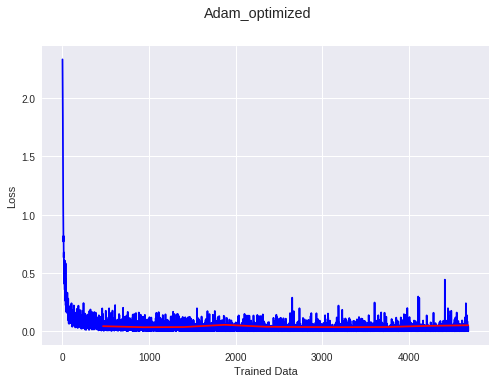

In [0]:
train_l_ADAM, valid_x_ADAM, valid_l_ADAM = evalopt('Adam', 0.001, 0.5, 0.55)
plots('Adam lr = 0.001 Betas = (0.5, 0.55)', train_l_ADAM, valid_x_ADAM, valid_l_ADAM)

On one hand, the convergence speed is the same as the case with default betas and lr = 0.001. This means that convergence speed doesn't depend on the betas.

On the other hand, the loss values during the process is higher (not that much).

What if the mean has a higher beta than the variance?

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.999, 0.85)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Training with opt: Adam -- Train epoch: 1 -- Validation Average loss: 3063490792.4480, Accuracy: 1555/10000 (16%)
Training with opt: Adam -- Train epoch: 2 -- Validation Average loss: 2320560795995850827366400.0000, Accuracy: 1128/10000 (11%)
Training with opt: Adam -- Train epoch: 3 -- Validation Average loss: 31447350655862890421026816.0000, Accuracy: 964/10000 (10%)
Training with opt: Adam -- Train epoch: 4 -- Validation Average loss: 1180859583479925082210868796588032.0000, Accuracy: 931/10000 (9%)
Training with opt: Adam -- Train epoch: 5 -- Validation Average loss: nan, Accuracy: 980/10000 (10%)
Training with opt: Adam -- Train epoch: 6 -- Validation Average loss: nan, Accuracy: 980/10000 (10%)
Training with opt: Adam -- Train epoch: 7 -- Validation Average loss: nan, Accuracy: 980/10000 (10%)
Training with opt: Adam -- Train epoch: 8 -- Validation Average loss:

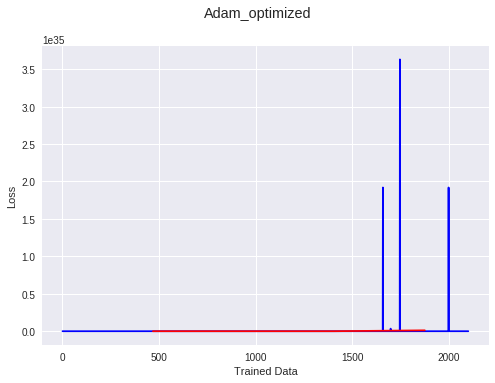

In [0]:
train_l_ADAM, valid_x_ADAM, valid_l_ADAM = evalopt('Adam', 0.001, 0.999, 0.85)
plots('Adam lr = 0.001 Betas = (0.999, 0.85)', train_l_ADAM, valid_x_ADAM, valid_l_ADAM)

We clearly don't reach convergence, even with a good learning rate value. We deduce then, that it's really important to have a higher value on the variance beta than the mean one.

What happens if we really lower the betas?

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.01, 0.01)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Training with opt: Adam -- Train epoch: 1 -- Validation Average loss: 0.0586, Accuracy: 9826/10000 (98%)
Training with opt: Adam -- Train epoch: 2 -- Validation Average loss: 0.1049, Accuracy: 9738/10000 (97%)
Training with opt: Adam -- Train epoch: 3 -- Validation Average loss: 0.0427, Accuracy: 9890/10000 (99%)
Training with opt: Adam -- Train epoch: 4 -- Validation Average loss: 0.0469, Accuracy: 9879/10000 (99%)
Training with opt: Adam -- Train epoch: 5 -- Validation Average loss: 0.0737, Accuracy: 9850/10000 (98%)
Training with opt: Adam -- Train epoch: 6 -- Validation Average loss: 0.0700, Accuracy: 9875/10000 (99%)
Training with opt: Adam -- Train epoch: 7 -- Validation Average loss: 0.1013, Accuracy: 9826/10000 (98%)
Training with opt: Adam -- Train epoch: 8 -- Validation Average loss: 0.0771, Accuracy: 9872/10000 (99%)
Training with opt: Adam -- Train epoch: 9

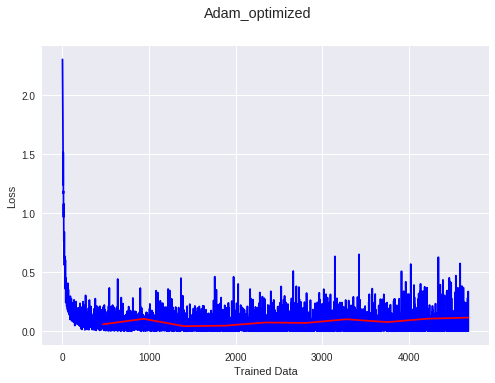

In [0]:
train_l_ADAM, valid_x_ADAM, valid_l_ADAM = evalopt('Adam', 0.001, 0.01, 0.01)
plots('Adam lr = 0.001 Betas = (0.01, 0.01)', train_l_ADAM, valid_x_ADAM, valid_l_ADAM)

If we really lower the bettas we see that the loss drops on the begging but we dont have really good values towards the end, they increase during the times and specially because of the variance. It won't converge to zero with time

## RMSprop Overview

Now, we are going to do the same for the RMSprop. This optimizer changes depending on the learning rate. We can change it by modifying the second parameter in the function below. There are other parameters, but they are not as important as the lr, so we have them as default values.

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)
Training with opt: RMS -- Train epoch: 1 -- Validation Average loss: 2.3031, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch: 2 -- Validation Average loss: 2.3018, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch: 3 -- Validation Average loss: 2.3015, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch: 4 -- Validation Average loss: 2.3017, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch: 5 -- Validation Average loss: 2.3018, Accuracy: 1028/10000 (10%)
Training with opt: RMS -- Train epoch: 6 -- Validation Average loss: 2.3019, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch: 7 -- Validation Average loss: 2.3014, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch: 8 -- Validation Average loss: 2.3016, Accuracy: 1135/10000 (11%)
Training with opt: RMS -- Train epoch:

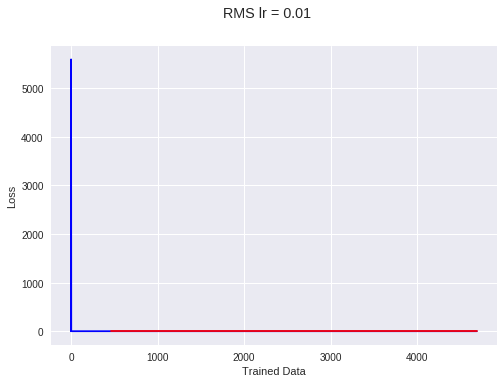

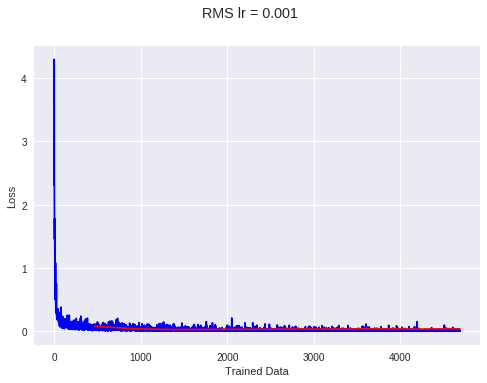

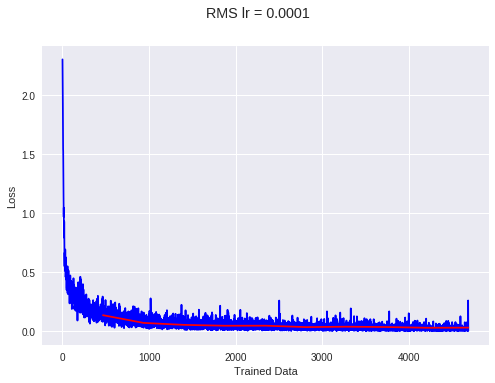

In [10]:
train_l_RMS_lr1, valid_x_RMS_lr1, valid_l_RMS_lr1 = evalopt('RMS', 0.01)
train_l_RMS_lr2, valid_x_RMS_lr2, valid_l_RMS_lr2 = evalopt('RMS', 0.001)
train_l_RMS_lr3, valid_x_RMS_lr3, valid_l_RMS_lr3 = evalopt('RMS', 0.0001)
plots('RMS lr = 0.01', train_l_RMS_lr1, valid_x_RMS_lr1, valid_l_RMS_lr1)
plots('RMS lr = 0.001', train_l_RMS_lr2, valid_x_RMS_lr2, valid_l_RMS_lr2)
plots('RMS lr = 0.0001', train_l_RMS_lr3, valid_x_RMS_lr3, valid_l_RMS_lr3)

Ii is ought to notice that altough it can not be seen very well in the first graphic, the error for a lr = 0.1 is very high, as it can be noticed in the Validation Error logs.

After testing different values for the lr we have seen that the ideal value is lr=0.001. This can be seen from the Validation Average loss, the accuracy and the convergence of the graphic above.

## Adadelta Overview

Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size.

With Adadelta, we do not even need to set a default learning rate, as it has been eliminated from the update rule.

We will test Adadelta differing values of rho (0.01 and 0.95):

Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 1.0
    rho: 0.01
    weight_decay: 0
)
Training with opt: Delta -- Train epoch: 1 -- Validation Average loss: 0.0542, Accuracy: 9811/10000 (98%)
Training with opt: Delta -- Train epoch: 2 -- Validation Average loss: 0.0357, Accuracy: 9891/10000 (99%)
Training with opt: Delta -- Train epoch: 3 -- Validation Average loss: 0.0308, Accuracy: 9899/10000 (99%)
Training with opt: Delta -- Train epoch: 4 -- Validation Average loss: 0.0267, Accuracy: 9914/10000 (99%)
Training with opt: Delta -- Train epoch: 5 -- Validation Average loss: 0.0273, Accuracy: 9927/10000 (99%)
Training with opt: Delta -- Train epoch: 6 -- Validation Average loss: 0.0330, Accuracy: 9911/10000 (99%)
Training with opt: Delta -- Train epoch: 7 -- Validation Average loss: 0.0310, Accuracy: 9929/10000 (99%)
Training with opt: Delta -- Train epoch: 8 -- Validation Average loss: 0.0282, Accuracy: 9937/10000 (99%)
Training with opt: Delta -- Train epoch: 9 -- Validation Ave

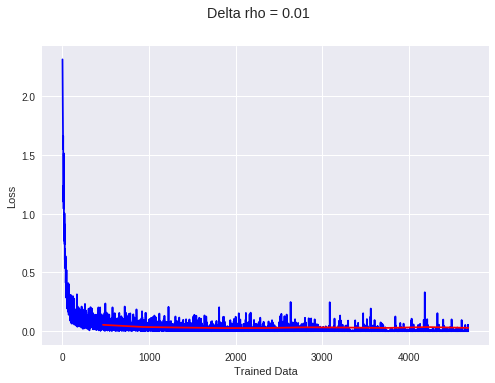

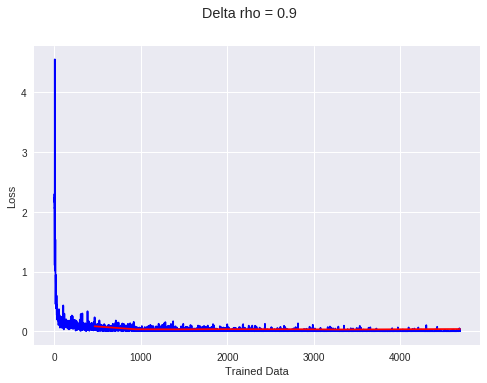

In [11]:
train_l_delta_r1, valid_x_delta_r1, valid_l_delta_r1 = evalopt('Delta', 0.01)
train_l_delta_r2, valid_x_delta_r2, valid_l_delta_r2 = evalopt('Delta', 0.95)
plots('Delta rho = 0.01', train_l_delta_r1, valid_x_delta_r1, valid_l_delta_r1)
plots('Delta rho = 0.9', train_l_delta_r2, valid_x_delta_r2, valid_l_delta_r2)

As we can see, there is not much difference between one case and the other. However we can see in the training error evolution that a higher rho, learns the training data data faster. So we can assume Adadelta is an optimizer that adapts properly its parameters in order to get the best results in terms of accuracy.

## Final Comparison

Now that we have reviewed each method and the influences of their parameters let's put together the best performances and compare them.

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.04
    momentum: 0.5
    nesterov: 1
    weight_decay: 0
)
Training with opt: SGD -- Train epoch: 1 -- Validation Average loss: 0.0663, Accuracy: 9788/10000 (98%)
Training with opt: SGD -- Train epoch: 2 -- Validation Average loss: 0.0473, Accuracy: 9865/10000 (99%)
Training with opt: SGD -- Train epoch: 3 -- Validation Average loss: 0.0501, Accuracy: 9836/10000 (98%)
Training with opt: SGD -- Train epoch: 4 -- Validation Average loss: 0.0511, Accuracy: 9829/10000 (98%)
Training with opt: SGD -- Train epoch: 5 -- Validation Average loss: 0.0397, Accuracy: 9873/10000 (99%)
Training with opt: SGD -- Train epoch: 6 -- Validation Average loss: 0.0261, Accuracy: 9920/10000 (99%)
Training with opt: SGD -- Train epoch: 7 -- Validation Average loss: 0.0308, Accuracy: 9890/10000 (99%)
Training with opt: SGD -- Train epoch: 8 -- Validation Average loss: 0.0277, Accuracy: 9909/10000 (99%)
Training with opt: SGD -- Train epoch: 9 -- Validation Ave

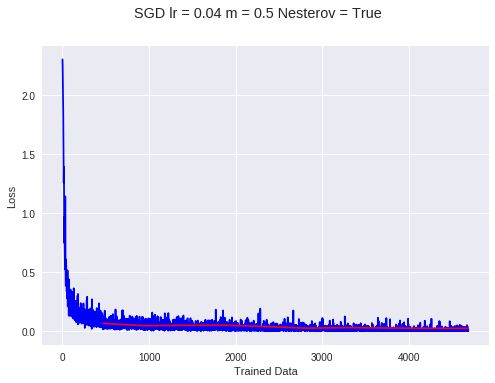

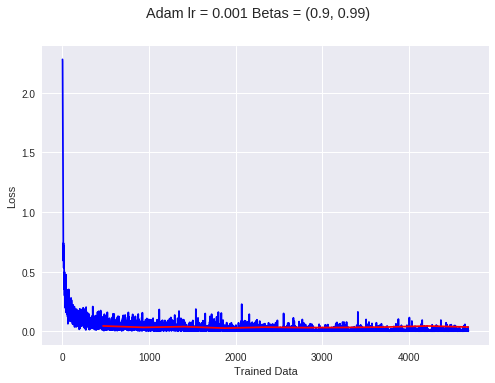

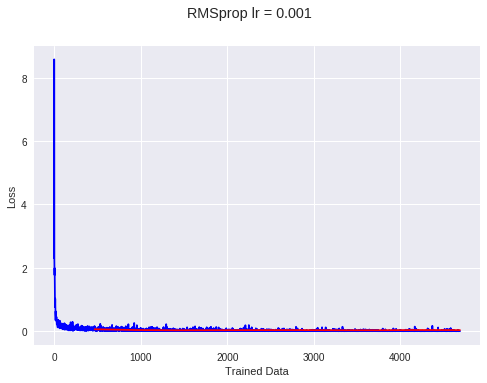

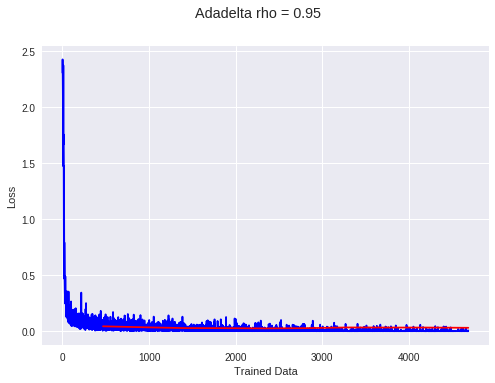

In [12]:
train_l_SGD_final, valid_x_SGD_final, valid_l_SGD_final = evalopt('SGD', 0.04, 0.5, 1)
train_l_ADAM_final, valid_x_ADAM_final, valid_l_ADAM_final = evalopt('Adam', 0.001, 0.9, 0.99)
train_l_RMS_final, valid_x_RMS_final, valid_l_RMS_final = evalopt('RMS', 0.001)
train_l_delta_final, valid_x_delta_final, valid_l_delta_final = evalopt('Delta', 0.95)
plots('SGD lr = 0.04 m = 0.5 Nesterov = True', train_l_SGD_final, valid_x_SGD_final, valid_l_SGD_final)
plots('Adam lr = 0.001 Betas = (0.9, 0.99)', train_l_ADAM_final, valid_x_ADAM_final, valid_l_ADAM_final)
plots('RMSprop lr = 0.001', train_l_RMS_final, valid_x_RMS_final, valid_l_RMS_final)
plots('Adadelta rho = 0.95', train_l_delta_final, valid_x_delta_final, valid_l_delta_final)



So with these four final examples we can see that all optimizers are good at tackling this classification task. However we have noticed that some algorithms (specially SGD) require much more parameter tuning than others. For example, as it has been seen in the previous sections, for SGD, Adam and RMSprop it is very relevant to tune the learning rate to achieve good results, but this is not the case of Adadelta where the default parameters perform a really good job. 


To sum up we can conclude that as many things in life this is not a black or white matter, and some algorithms may work better than others in different scenarios. But with our study, in this case we can observe that Adadelta is the algorithm that obtains a faster and easier performance with the added value that does not require much parameterization as other algorithms do. The best results are given by the RMSprop.
